# 04_Regression

분류문제와 달리 회귀는 레이블 대신에 연속적인 값을 예측하는 회귀(regression)입니다. 예를 들어 기상 데이터가 주어졌을 때 내일 기온을 예측하거나, 소프트웨어 명세가 주어졌을 때 소프트웨어 프로젝트가 완료될 시간을 예측하는 것입니다.

## Setup

In [118]:
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()

def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()  

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
import warnings
warnings.filterwarnings("ignore")

<br> 

## 4.1 The Boston Housing Price dataset

1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해 보겠습니다. 여기서 사용할 데이터셋은 데이터포인트가 506개로 비교적 갯수가 적습니다. 404개는 훈련샘플로, 102개는 테스트 샘플로 나뉘어 있습니다. 입력 데이터에 있는 각 특성(예를 들어 범죄율)은 스케일이 서로 다릅니다. 어떤 값은 0과 1사이의 비율을 나타내고, 어떤 것은 1과 12사이의 값을 가지거나 1과 100사이의 값을 가집니다.

In [2]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

<br>

데이터를 살표보겠습니다.

In [3]:
print(f"train_data.shape: {train_data.shape}")
print(f"test_data.shape: {test_data.shape}")

train_data.shape: (404, 13)
test_data.shape: (102, 13)


<br>

여기서 볼 수 있듯이 404개의 훈련 샘플과 102개의 테스트 샘플이 있고 모두 13개의 수치 특성이 있습니다. 이 특성들은 1인당 범죄율, 주택당 평균 방의 갯수, 고속도로 접근성 등입니다.

타깃은 주택의 중간 가격으로 천 달러 단위입니다.

In [15]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

이 가격은 일반적으로 1만 달러에서 5만달러 사이입니다. 1970년대 중반이며 아직 인플레이션에 영향을 받지 않은 가격입니다.

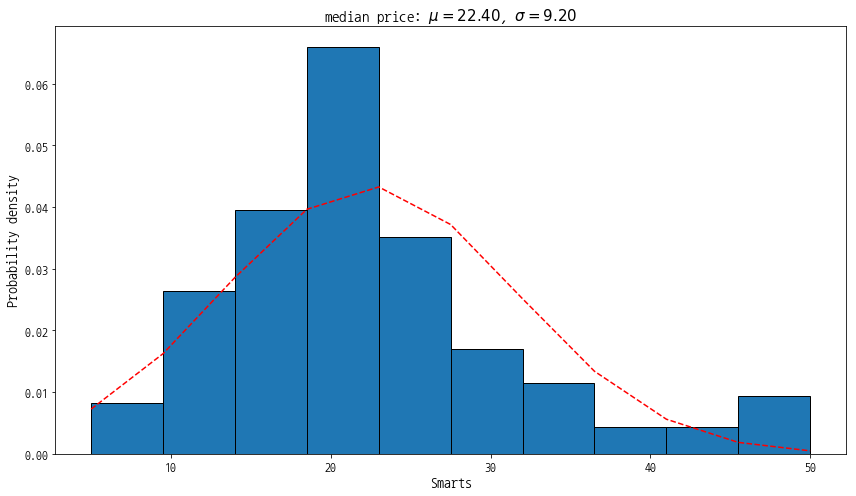

In [54]:
mu = np.mean(train_targets, axis=0)
sigma = np.std(train_targets, axis=0)
x = train_targets

num_bins = 10

# the histogram of the data
plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(x, num_bins, density=True, edgecolor="k")

# add a 'best fit' line
from scipy.stats import norm
rv = norm(mu, sigma)
y = rv.pdf(bins)

plt.plot(bins, y, 'r--')
plt.xlabel('Smarts')
plt.ylabel('Probability density')
plt.title(r'median price: $\mu={:2.2f}$, $\sigma={:2.2f}$'.format(mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()
plt.show()

<br>

## 4.2 Preparing the data

상이한 스케일을 가진 값을 신경망에 주입하면 문제가 됩니다. 네트워크가 이런 다양한 데이터에 자동으로 맞추려고 할 수 있지만 이는 확실히 학습을 더 어렵게 만듭니다. 이런 데이터를 다룰 때 대표적인 방법은 특성별로 정규화를 하는 것입니다. 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준편차로 나눕니다. 특성의 중앙이 0 근처에 맞추어지고 표준 편차가 1이됩니다.

In [61]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

<br>

**테스트 데이터를 정규화할 때 사용한 값이 훈련데이터에서 계산한 값임을 주의하세요** 머신 러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안됩니다.

<br>

## 4.3 Building your network

샘플 갯수가 적기 때문에 64개의 유닛을 가진 2개의 은닉 층으러 작은 네트워크를 구성하여 사용하겠습니다. 일반적으로 훈련 데이터의 갯수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법입니다.

In [63]:
# 동일한 모델을 여러번 사용할 것이므로 함수로 정의합니다.
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

In [64]:
def build_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer=optimizers.Adam(lr=0.001), 
                  loss = losses.mean_squared_error, 
                  metrics = [metrics.mean_absolute_error])
    
    return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없습니다(선형 층이라고 부릅니다). 이것이 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성입니다. 활성화 함수를 적용하면 출력 값의 범위를 제한하게 됩니다. 예를 들어 마지막 층에 sigmoid 활성화 함수를 적용하면 네트워크가 0과 1사이의 값을 예측하도록 학습될 것입니다. 여기서는 마지막층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습됩니다.  

이 모델은 mse(mean squared error) 손실함수를 사용하여 컴파일합니다. 즉 예측과 타깃 사이 거리의 제곱을 구하는 것입니다. **회귀 문제에서 주로 사용되는 손실 함수 입니다.**  

훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차(Mean Absolute Error, MAE)를 측정합니다. 이는 예측과 타깃 사이 거리의 절대값입니다. 예를 들어 MAE가 0.5이면 평균적으로 500달러정도 차이가 난다는 뜻입니다(단위가 천달러 이기 때문에).

<br>

## 4.4 Validating your approach using K-fold validation  

(훈련에 사용할 에포크의 수 같은) 매개변수들을 조정하면서 모델을 평가하기 위해 이전 에제에서 했던 것처럼 데이터를 훈련 세트와 검증 세트로 나눕니다. 데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아집니다(약 100개의 샘플). 결국 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택되었는지에 따라 검증 점수가 크게 달라집니다. 검증 세트의 분할에 대한 검증 점수의 분산이 높습니다. 이렇게 되면 신뢰 있는 모델 평가를 할 수 없습니다.  

이런 상황에서 가장 좋은 방법은 K-겹 교차 검증(K-fold cross-validation)입니다. 아래 그림을 참고하세요. 데이터를 K개의 분할(즉, fold)로 나누고 (일반적으로 5 또는 10), K개의 모델을 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법입니다. 모델이 검증 점수는 K개의 검증 점수 평균이 됩니다.

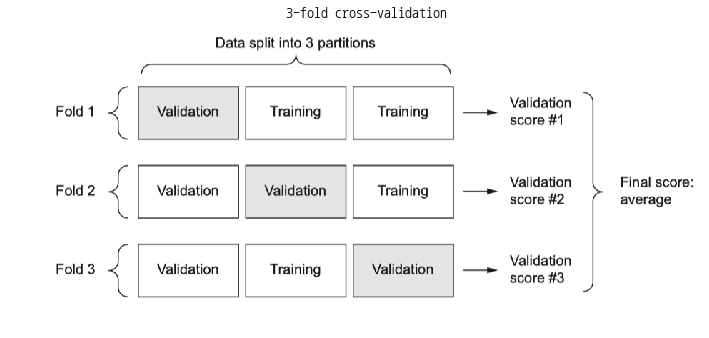

In [66]:
plt.figure(figsize=(12, 7))
plt.title("3-fold cross-validation", fontsize=14)
plot_external2("./images/ch04/1.png")
plt.show()

In [126]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\thistory key: {}".format(list(logs.keys())))
        print("\repoch: {}, loss: {}".format(epoch+1, logs["loss"]), end=" ")

        if (epoch+1) % 30 == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("mae: {:.5f}".format(logs["mean_absolute_error"]), end="\n")
#             print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
#             print("val_acc: {:.5f}".format(logs["mean_absolute_error"]))

In [127]:
import numpy as np

In [131]:
k = 5
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [132]:
for i in range(k):
    print("\nprocessing fold # %d" % (i+1))
    X_valid = train_data[i*num_val_samples : (i+1)*num_val_samples]
    y_valid = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    X_train = np.concatenate([train_data[: i*num_val_samples],
                              train_data[(i+1)*num_val_samples: ]], axis=0)
    
    y_train = np.concatenate([train_targets[: i*num_val_samples],
                              train_targets[(i+1)*num_val_samples: ]], axis=0)
    
    model = build_model()
    model.fit(X_train, y_train,
              epochs=num_epochs, 
              batch_size=1,
              verbose=0,
              callbacks=[LossAndErrorPrintingCallback(epochs=num_epochs)])
    
    val_mse, val_mae = model.evaluate(X_valid, y_valid, verbose=0)
    all_scores.append(val_mae)


processing fold # 1
epoch: 1, loss 26.02876 	history key: ['loss', 'mean_absolute_error']
Epoch 30/100 loss: 6.67150 mae: 1.89321
Epoch 60/100 loss: 4.57430 mae: 1.57483
Epoch 90/100 loss: 3.08383 mae: 1.35588
Epoch 100/100 loss: 2.89634 mae: 1.33633

processing fold # 2
epoch: 1, loss 0.00455 	history key: ['loss', 'mean_absolute_error']
Epoch 30/100 loss: 6.45805 mae: 1.83414
Epoch 60/100 loss: 3.19565 mae: 1.36378
Epoch 90/100 loss: 2.14756 mae: 1.12512
Epoch 100/100 loss: 2.17782 mae: 1.09833

processing fold # 3
epoch: 1, loss 0.70067 	history key: ['loss', 'mean_absolute_error']
Epoch 30/100 loss: 6.29768 mae: 1.80031
Epoch 60/100 loss: 3.34684 mae: 1.36551
Epoch 90/100 loss: 2.05136 mae: 1.04584
Epoch 100/100 loss: 2.09474 mae: 1.07709

processing fold # 4
epoch: 1, loss 4.56525 	history key: ['loss', 'mean_absolute_error']
Epoch 30/100 loss: 5.97059 mae: 1.80169
Epoch 60/100 loss: 2.60951 mae: 1.23271
Epoch 90/100 loss: 1.72977 mae: 1.00901
Epoch 100/100 loss: 1.61904 mae: 0.9

다음과 같은 결과를 얻습니다.

In [133]:
all_scores

[1.883889, 3.4355793, 2.0814645, 2.6556711, 2.4830031]

In [134]:
np.mean(all_scores)

2.5079217

<br>

검증 세트가 다르므로 확실히 검증 점수가 1.8 ~ 3.4 까지 변화가 큽니다. 평균값(2.5)이 다른 값보다 훨씬 신뢰할 만합니다. 이것이 K-겹 교차 검증의 핵심입니다. 이 예에서는 평균적으로 2천500달러 정도 차이가 납니다. 주택 가격의 범위가 1만 달러에서 5만 달러 사이인 것을 감안하면 비교적 큰 값입니다.

<br>

신경망을 조금 더 오래 500에포크 동안 훈련해보겠습니다. 각 에포크마다 검증 점수를 로그에 저장하겠습니다.

In [144]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\nhistory key: {}".format(list(logs.keys())))
        print("\repoch: {}, loss: {}".format(epoch+1, logs["loss"]), end=" ")

        if (epoch+1) % 50 == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("mae: {:.5f}".format(logs["mean_absolute_error"]), end=" ")
            print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
            print("val_acc: {:.5f}".format(logs["mean_absolute_error"]))

In [145]:
import numpy as np

In [146]:
k = 5
num_val_samples = len(train_data) // k
num_epochs = 500
histories = {"loss": [], "val_loss": [], "mae": [], "val_mae": []}

In [147]:
for i in range(k):
    print("\nprocessing fold # %d" % (i+1))
    X_valid = train_data[i*num_val_samples : (i+1)*num_val_samples]
    y_valid = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    X_train = np.concatenate([train_data[: i*num_val_samples],
                              train_data[(i+1)*num_val_samples: ]], axis=0)
    
    y_train = np.concatenate([train_targets[: i*num_val_samples],
                              train_targets[(i+1)*num_val_samples: ]], axis=0)
    
    model = build_model()
    history = model.fit(X_train, y_train,
              epochs=num_epochs, 
              batch_size=1,
              verbose=0,
              validation_data=(X_valid, y_valid),             
              callbacks=[LossAndErrorPrintingCallback(epochs=num_epochs)])
    
    history_dict = history.history
    histories["loss"].append(history_dict["loss"])
    histories["mae"].append(history_dict["mean_absolute_error"])
    histories["val_loss"].append(history_dict["val_loss"])
    histories["val_mae"].append(history_dict["val_mean_absolute_error"])


processing fold # 1
epoch: 1, loss 220.58925 
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 50/500 loss: 5.46766 mae: 1.62614 val_loss: 8.02485 val_acc: 1.62614
Epoch 100/500 loss: 2.97125 mae: 1.34536 val_loss: 4.92567 val_acc: 1.34536
Epoch 150/500 loss: 2.01239 mae: 1.01583 val_loss: 5.62465 val_acc: 1.01583
Epoch 200/500 loss: 1.15636 mae: 0.81181 val_loss: 6.19216 val_acc: 0.81181
Epoch 250/500 loss: 0.86936 mae: 0.67515 val_loss: 5.89602 val_acc: 0.67515
Epoch 300/500 loss: 0.98403 mae: 0.70594 val_loss: 5.88049 val_acc: 0.70594
Epoch 350/500 loss: 1.16890 mae: 0.77110 val_loss: 7.88745 val_acc: 0.77110
Epoch 400/500 loss: 0.65033 mae: 0.57894 val_loss: 6.65829 val_acc: 0.57894
Epoch 450/500 loss: 0.70505 mae: 0.61722 val_loss: 6.43541 val_acc: 0.61722
Epoch 500/500 loss: 0.56705 mae: 0.54654 val_loss: 6.49287 val_acc: 0.54654

processing fold # 2
epoch: 1, loss 1.31966 
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mea

모든 폴드에 대해 에포크의 점수 평균을 계산합니다.

In [178]:
average_mae = np.mean(histories["mae"], axis=0)
val_average_mae = np.mean(histories["val_mae"], axis=0)

average_loss = [np.mean([x[i] for x in histories["loss"]]) for i in range(num_epochs)]
val_average_loss = [np.mean([x[i] for x in histories["val_loss"]]) for i in range(num_epochs)]

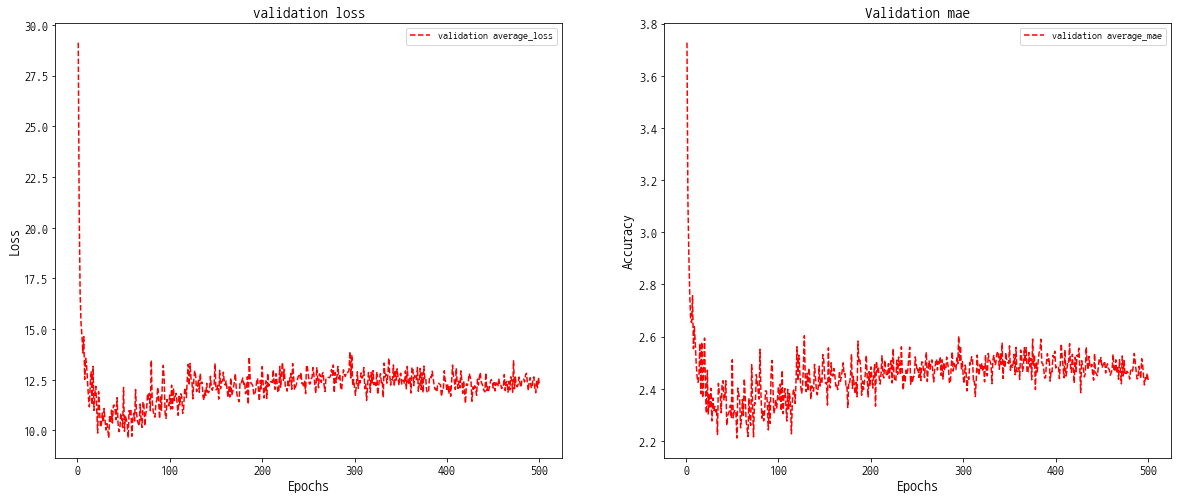

In [191]:
epochs = range(1, len(average_loss)+1)

plt.figure(figsize=(20, 8))
plt.subplot(121)
# plt.plot(epochs, average_loss, "b-", label="average_loss")
plt.plot(epochs, val_average_loss, "r--", label="validation average_loss")
plt.title("validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
# plt.plot(epochs, average_mae, "b-", label="average_mae")
plt.plot(epochs, val_average_mae, "r--", label="validation average_mae")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation mae")
plt.legend()

plt.show()

<br>
이 그래프는 범위가 크고 변동이 심하기 때문에 보기가 어렵습니다.  

- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외시킵니다.  
- 부드러운 곡선을 얻기 위해 지수이동평균으로 대체합니다.

In [184]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [186]:
smooth_average_loss = smooth_curve(average_loss[10:])
smooth_val_average_loss = smooth_curve(val_average_loss[10:])

smooth_average_mae = smooth_curve(average_mae[10:])
smooth_val_average_mae = smooth_curve(val_average_mae[10:])

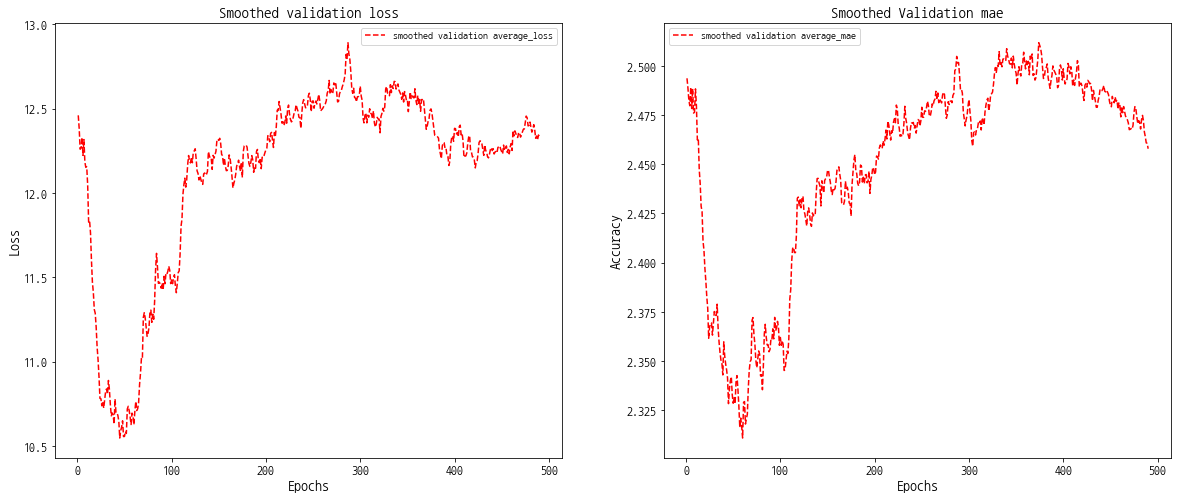

In [192]:
epochs = range(1, len(smooth_average_loss)+1)

plt.figure(figsize=(20, 8))
plt.subplot(121)
# plt.plot(epochs, smooth_average_loss, "b-", label="smoothed average_loss")
plt.plot(epochs, smooth_val_average_loss, "r--", label="smoothed validation average_loss")
plt.title("Smoothed validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
# plt.plot(epochs, smooth_average_mae, "b-", label="smoothed average_mae")
plt.plot(epochs, smooth_val_average_mae, "r--", label="smoothed validation average_mae")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Smoothed Validation mae")
plt.legend()

plt.show()

<br>

이 그래프를 보면 MAE가 80번째 에포크 이후에 줄어드는 것을 멈추었습니다. 이 지점 이후로는 과대적합이 시작됩니다. 

In [193]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}'.format(self.epoch+1, logs['loss']), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\nhistory key: {}".format(list(logs.keys())))
        print("\repoch: {}, loss: {}".format(epoch+1, logs["loss"]), end=" ")

        if (epoch+1) % 20 == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("mae: {:.5f}".format(logs["mean_absolute_error"]), end="\n")
#             print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
#             print("val_acc: {:.5f}".format(logs["mean_absolute_error"]))

In [195]:
import numpy as np

In [196]:
num_epochs = 80

In [199]:
model = build_model()
history = model.fit(train_data, train_targets,
                    epochs=num_epochs, 
                    batch_size=16,
                    verbose=0,
                    callbacks=[LossAndErrorPrintingCallback(epochs=num_epochs)])

history_dict = history.history
loss = history_dict["loss"]
mae = history_dict["mean_absolute_error"]

smooth_loss = smooth_curve(loss)
smooth_mae = smooth_curve(mae)

epoch: 1, loss 325.21695 
history key: ['loss', 'mean_absolute_error']
Epoch 20/80 loss: 11.68941 mae: 2.40235
Epoch 40/80 loss: 8.22420 mae: 2.04674
Epoch 60/80 loss: 6.69927 mae: 1.84331
Epoch 80/80 loss: 5.48038 mae: 1.65533


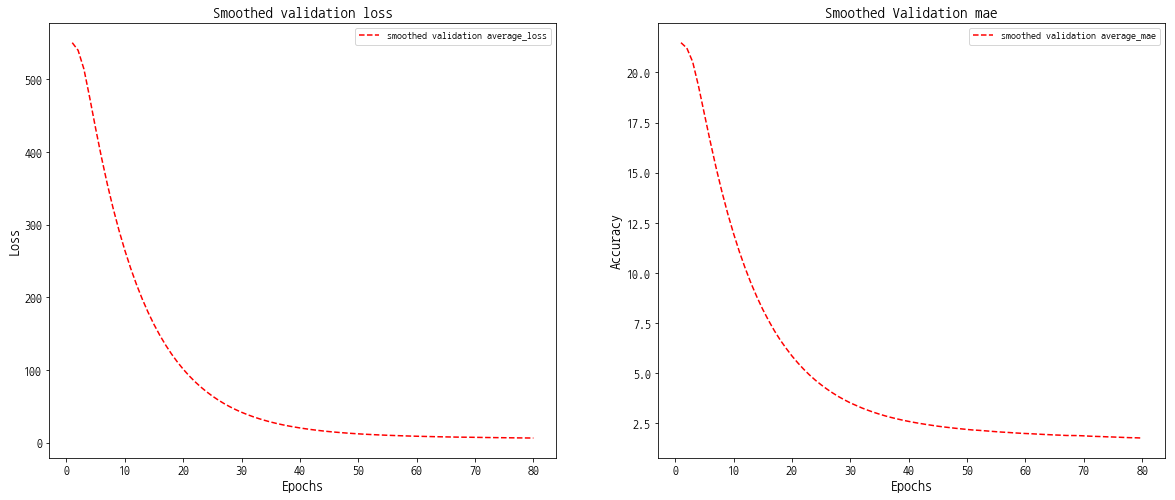

In [210]:
epochs = range(1, len(smooth_loss)+1)

plt.figure(figsize=(20, 8))
plt.subplot(121)
# plt.plot(epochs, smooth_average_loss, "b-", label="smoothed average_loss")
plt.plot(epochs, smooth_loss, "r--", label="smoothed validation average_loss")
plt.title("Smoothed validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
# plt.plot(epochs, smooth_average_mae, "b-", label="smoothed average_mae")
plt.plot(epochs, smooth_mae, "r--", label="smoothed validation average_mae")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Smoothed Validation mae")
plt.legend()

plt.show()

In [211]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 4ms/sample - loss: 18.7733 - mean_absolute_error: 2.6675


최종 모델 평가 결과 약 2,667달러 정도 차이가 납니다.